# Classification Models for Credit Card Fraud Detection on an Imbalanced Dataset
### University of Maryland, Baltimore County (UMBC): DATA601 - Intro to Data Science Project  
#### Matthew Han - mhan4@umbc.edu, Abhinaya Mudunuri - hu03574@umbc.edu, Suhani Kalpeshkumar Shah - suhanis1@umbc.edu

We import necessary libraries and define the class Transaction, which holds all the predictive features for each row/instance in creditcard.csv.
Also initialize all_transactions which holds all instances of Transaction loaded from creditcard.csv

In [55]:
#%pip install csv
#%pip install numpy
#%pip install pandas
#%pip install imblearn
#%pip install matplotlib

In [56]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
import copy

class Transaction:
    def __init__(self, row):
        self.Time = row[0]
        self.V = row[1:29] 
        self.Amount = row[29]
        self.Class = row[30]

all_transactions = [] #List of all transactions from the .csv file

Open creditcard.csv and cast each row to an new instance of Transaction, then append each new instance to all_transactions.

In [57]:
f = open('./creditcard.csv',newline='') #Open the csv file
reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC) #quoting=csv.QUOTE_NONNUMERIC places quotes around any values that are not integers/floats/numeric

print(next(reader))

next(reader) #Iterate to next row to skip the first row that is just the labels for each column
for row in reader: # A list of rows
    NewTransaction = Transaction(row) #Create new Transaction instance, and load the data from the csv file
    all_transactions.append(NewTransaction) #Append the instance to the total list of all transactions

f.close() #Close file after loading is finished

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Bar graph visualization of the dataset class distribution

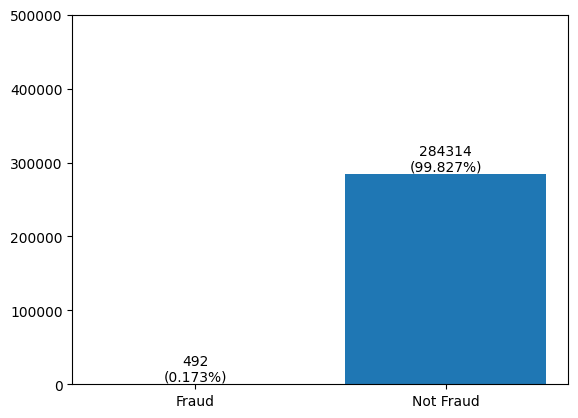

In [58]:
#Extract class values from the data
class_distribution = []
for each in all_transactions:
    class_distribution.append(each.Class)

#Count cases where class=1 and class=0
count_fraud = 0
count_not_fraud = 0
for each in class_distribution:
    if each == '0':
        count_not_fraud += 1
    elif each == '1':
        count_fraud += 1

#Define labels and values for the bar graph
label = ['Fraud','Not Fraud']
values = [count_fraud, count_not_fraud]

#Plot the bargraph, set ylimit to 500k and add text to each bar, which lists the total count and percentage representation of each class
fig, ax = plt.subplots()
ax.bar(label, values)
ax.set_ylim(0, 500000)
for i in range(len(values)):
    ax.text(i, values[i], str(values[i])+'\n'+'('+str(round(values[i]/len(class_distribution)*100,3))+'%'+')', ha='center', va='bottom')


We now shift to the training phase of the classification models. Due to the dataset being extremely unbalanced we apply the Synthetic Minority Oversampling Technique (SMOTE) to oversample (generate) fake cases of the minority class: where Class=1(fraud=true).

In [ ]:
training_data = [] #80% of original dataset
test_data = [] #The remaining 20%
percent80 = int(len(all_transactions) * 0.8) #Index of the dataset at the 80% cutoff

training_data = all_transactions[:percent80]
test_data = all_transactions[percent80:]
print(len(training_data) / len(all_transactions))
print(len(test_data) / len(all_transactions))
print(len(all_transactions))

features = [] #extract features/attributes from the training dataset to use in oversampling
classes = []
for each in training_data:
    temp = []
    temp.append(each.Time)
    temp.extend(each.V)
    temp.append(each.Amount)
    features.append(temp)
    classes.append(each.Class)
      
"""count = 0
for each in training_data:
    if each.Class == '1':
        count += 1
print(count)
"""
oversample = imblearn.over_sampling.SMOTE()
features, classes = oversample.fit_resample(features, classes)



0.7999971910704129
0.20000280892958716
284806
